# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Import and Clean Wind Data

In [15]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [16]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [17]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [18]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [19]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [20]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [21]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [22]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


## Find optimal Shift size using the best window size

In [44]:
# add the weather columns to our x_columns

best_x_window = pd.Timedelta('28 days')
best_y_window = pd.Timedelta('1 day')
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta('1 hour')
max_shift = pd.Timedelta('7 days')
shift = iteration_delta
best_accuracy = 0
best_recall = 0
best_precision = 0
best_shift = 0

shift_sizes = []
accuracies = []

max_iter = 25000
loss = "log"

while shift <= max_shift:

    # Windowize
    print("current shift size", shift)
    print("Windowizing 2017 data sets:", train_index)
    train = hf.windowize(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=best_x_window, y_win_size=best_y_window, shift=shift)
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=best_x_window, y_win_size=best_y_window, shift=shift)
    print()
    
    # Combine the data sets

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns )
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    shift_sizes.append(shift)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_shift = shift
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
    # Once we hit 24 hours, start increasing shift by 1 day
    if shift >= pd.Timedelta('1 day'):
        iteration_delta = pd.Timedelta('1 day')
    shift += iteration_delta

current shift size 0 days 01:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.840925700365408
Test model recall: 0.8189220628150445
Test model precision: 0.9190600522193212

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8579780755176614
Test model recall: 0.847227607599845
Test model precision: 0.9203875315922494

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8567600487210718
Test model recall: 0.8553702985653354
Test model precision: 0.9111937216026436

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8416950803701899
Test model recall: 0.8188854489164087
Test model precision: 0.9208006962576153

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8582562104237701
Test model recall: 0.846749226006192
Test model precision: 0.9216512215669755

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8567949342425718
Test model recall: 0.8544891640866873
Test model precision: 0.912396694214876

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8378378378378378
Test model recall: 0.8160651920838184
Test model precision: 0.9163398692810457

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8575602629656683
Test model recall: 0.8451688009313155
Test model precision: 0.9213197969543148

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8371073776479182
Test model recall: 0.8265424912689173
Test model precision: 0.9056122448979592

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8412852969814996
Test model recall: 0.8198757763975155
Test model precision: 0.9182608695652174

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.857838364167478
Test model recall: 0.8478260869565217
Test model precision: 0.9191919191919192

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8568646543330087
Test model recall: 0.8555900621118012
Test model precision: 0.9107438016528926

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8416565164433617
Test model recall: 0.8210116731517509
Test model precision: 0.9173913043478261

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8611449451887941
Test model recall: 0.8501945525291829
Test model precision: 0.9219409282700421

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8404384896467723
Test model recall: 0.830739299610895
Test model precision: 0.9065817409766455

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8394160583941606
Test model recall: 0.8181818181818182
Test model precision: 0.9164490861618799

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8569343065693431
Test model recall: 0.8461538461538461
Test model precision: 0.9189873417721519

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8291970802919708
Test model recall: 0.8251748251748252
Test model precision: 0.8939393939393939

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8432708688245315
Test model recall: 0.8184281842818428
Test model precision: 0.9235474006116208

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8620102214650767
Test model recall: 0.8455284552845529
Test model precision: 0.9285714285714286

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.858603066439523
Test model recall: 0.8509485094850948
Test model precision: 0.9181286549707602

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8443579766536965
Test model recall: 0.822429906542056
Test model precision: 0.9198606271777003

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8638132295719845
Test model recall: 0.8504672897196262
Test model precision: 0.9254237288135593

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8599221789883269
Test model recall: 0.8598130841121495
Test model precision: 0.9108910891089109

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.838074398249453
Test model recall: 0.8153310104529616
Test model precision: 0.9176470588235294

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8577680525164114
Test model recall: 0.8432055749128919
Test model precision: 0.9236641221374046

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8512035010940919
Test model recall: 0.8501742160278746
Test model precision: 0.9070631970260223

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8442822384428224
Test model recall: 0.8217054263565892
Test model precision: 0.9217391304347826

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8613138686131386
Test model recall: 0.8488372093023255
Test model precision: 0.9240506329113924

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.829683698296837
Test model recall: 0.8217054263565892
Test model precision: 0.8983050847457628

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.839572192513369
Test model recall: 0.8135593220338984
Test model precision: 0.9230769230769231

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8556149732620321
Test model recall: 0.8389830508474576
Test model precision: 0.9252336448598131

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.839572192513369
Test model recall: 0.826271186440678
Test model precision: 0.9112149532710281

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8338192419825073
Test model recall: 0.8130841121495327
Test model precision: 0.9109947643979057

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8571428571428571
Test model recall: 0.8457943925233645
Test model precision: 0.9187817258883249

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8367346938775511
Test model recall: 0.8271028037383178
Test model precision: 0.9030612244897959

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8322784810126582
Test model recall: 0.81
Test model precision: 0.9152542372881356

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8512658227848101
Test model recall: 0.84
Test model precision: 0.9180327868852459

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8544303797468354
Test model recall: 0.84
Test model precision: 0.9230769230769231

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0.71

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH', 'Wind Speed', 'Temp C', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH', 'Wind Speed', 'Temp C', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8435374149659864
Test model recall: 0.8085106382978723
Test model precision: 0.9382716049382716

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8571428571428571
Test model recall: 0.8297872340425532
Test model precision: 0.9397590361445783

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8435374149659864
Test model recall: 0.8191489361702128
Test model precision: 0.927710843373494

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model ac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'Wind Speed', 'TMAX', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8394160583941606
Test model recall: 0.8187134502923976
Test model precision: 0.9150326797385621

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8613138686131386
Test model recall: 0.847953216374269
Test model precision: 0.9235668789808917

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8248175182481752
Test model recall: 0.8187134502923976
Test model precision: 0.89171974522293

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8521400778210116
Test model recall: 0.85625
Test model precision: 0.9013157894736842

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8560311284046692
Test model recall: 0.8625
Test model precision: 0.9019607843137255

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8443579766536965
Test model recall: 0.85625
Test model precision: 0.8896103896103896

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.8015564202334631
Test model rec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8347107438016529
Test model recall: 0.8187919463087249
Test model precision: 0.9037037037037037

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.859504132231405
Test model recall: 0.8523489932885906
Test model precision: 0.9136690647482014

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8429752066115702
Test model recall: 0.8389261744966443
Test model precision: 0.8992805755395683

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8558951965065502
Test model recall: 0.8493150684931506
Test model precision: 0.9185185185185185

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8558951965065502
Test model recall: 0.8561643835616438
Test model precision: 0.9124087591240876

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8427947598253275
Test model recall: 0.863013698630137
Test model precision: 0.8873239436619719

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8602620087336245
Test model recall: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8341013824884793
Test model recall: 0.8102189781021898
Test model precision: 0.9173553719008265

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8525345622119815
Test model recall: 0.8394160583941606
Test model precision: 0.92

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8294930875576036
Test model recall: 0.8175182481751825
Test model precision: 0.9032258064516129

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.82027649769

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8446601941747572
Test model recall: 0.8217054263565892
Test model precision: 0.9217391304347826

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8640776699029126
Test model recall: 0.8527131782945736
Test model precision: 0.9243697478991597

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8349514563106796
Test model recall: 0.8294573643410853
Test model precision: 0.8991596638655462

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy:

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8418367346938775
Test model recall: 0.819672131147541
Test model precision: 0.9174311926605505

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8622448979591837
Test model recall: 0.8442622950819673
Test model precision: 0.9279279279279279

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8622448979591837
Test model recall: 0.8524590163934426
Test model precision: 0.9203539823008849

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'pH', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8502673796791443
Test model recall: 0.8220338983050848
Test model precision: 0.9326923076923077

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8609625668449198
Test model recall: 0.847457627118644
Test model precision: 0.9259259259259259

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.839572192513369
Test model recall: 0.8305084745762712
Test model precision: 0.9074074074074074

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8659217877094972
Test model recall: 0.8584070796460177
Test model precision: 0.9238095238095239

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8659217877094972
Test model recall: 0.8584070796460177
Test model precision: 0.9238095238095239

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8715083798882681
Test model recall: 0.8584070796460177
Test model precision: 0.9326923076923077

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'pH', 'Wind Speed', 'pH (mV)', 'PRCP', 'rainy', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8488372093023255
Test model recall: 0.8365384615384616
Test model precision: 0.90625

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.872093023255814
Test model recall: 0.8653846153846154
Test model precision: 0.9183673469387755

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8488372093023255
Test model recall: 0.8461538461538461
Test model precision: 0.8979591836734694

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.813953488

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'PRCP', 'pH', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'PRCP', 'pH', 'pH (mV)', 'Wind Angle', 'rainy', 'SNWD', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.872093023255814
Test model recall: 0.8979591836734694
Test model precision: 0.88

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.872093023255814
Test model recall: 0.8979591836734694
Test model precision: 0.88

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8372093023255814
Test model recall: 0.8571428571428571
Test model precision: 0.8571428571428571

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8372093023255814
Test model recall: 0.8571428571428571
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Temp C', 'Wind Speed', 'pH', 'pH (mV)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Temp C', 'Wind Speed', 'pH', 'pH (mV)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8620689655172413
Test model recall: 0.8529411764705882
Test model precision: 0.90625

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8620689655172413
Test model recall: 0.8529411764705882
Test model precision: 0.90625

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8620689655172413
Test model recall: 0.8529411764705882
Test model precision: 0.90625

Training model with: ['ODOSat%', 'TMAX']
Test model accuracy: 0.8275862068965517
Test model recall: 0.7941176470588235
Test model preci

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Wind Angle', 'pH', 'pH (mV)', 'PRCP', 'rainy', 'SNWD', 'Temp C', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Wind Angle', 'pH', 'pH (mV)', 'PRCP', 'rainy', 'SNWD', 'Temp C', 'SNOW', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8837209302325582
Test model recall: 0.9166666666666666
Test model precision: 0.88

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8604651162790697
Test model recall: 0.875
Test model precision: 0.875

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7906976744186046
Test model recall: 0.875
Test model precision: 0.7777777777777778

Training model with: ['ODOSat%', 'TMAX']
Test model accuracy: 0.8372093023255814
Test model recall: 0.8333333333333334
Test model precision: 0.869565217391

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'pH', 'pH (mV)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'TMAX', 'Wind Speed', 'Temp C', 'pH', 'pH (mV)', 'rainy', 'SNWD', 'SNOW', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8275862068965517
Test model recall: 0.8235294117647058
Test model precision: 0.875

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8275862068965517
Test model recall: 0.8235294117647058
Test model precision: 0.875

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8275862068965517
Test model recall: 0.8235294117647058
Test model precision: 0.875

Training model with: ['ODOSat%', 'TMAX']
Test model accuracy: 0.7931034482758621
Test model recall: 0.7647058823529411
Test model precision: 

In [62]:
print("best accuracy", best_accuracy)
print("best recall", best_recall)
print("best precision", best_precision)
print("best shift", best_shift)

best accuracy 0.896551724137931
best recall 0.8823529411764706
best precision 0.9375
best shift 6 days 00:00:00


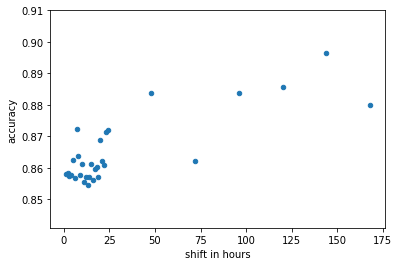

In [61]:
# Plot Accuracy vs shift size
df = pd.DataFrame({"accuracy": accuracies, 
                   "shift in hours": [(s.seconds / 60 / 60) + (s.days * 24) 
                             for s in shift_sizes]})
df.plot(kind="scatter", y="accuracy", x="shift in hours")

Accuracy could be biased as the shift size may be getting too large, reducing the dataset to just a few dozen points.